# Hierarchical Attention for Document Classification <a name='top'></a> 

## Overview
This notebook provides a **RAM-friendly** Keras implementation of the HAN model introduced in [Yang et al. (2016)](http://www.aclweb.org/anthology/N16-1174), with step-by-step explanations and links to relevant resources.

<img src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/HAN/han_architecture_illustration_small.bmp" alt="" width="550"/>


In my experiments on the **Amazon review dataset** (3,650,000 documents, 5 classes), I reach **62.6%** accuracy after 8 epochs, and **63.6%** accuracy (the accuracy reported in the paper) after 42 epochs. Each epoch takes about 20 mins on my TitanX GPU. I deployed the model as a [web app](https://safetyapp.shinyapps.io/DNLPvis/). As shown in the image below, you can paste your own review and visualize how the model pays attention to words and sentences.
<a href="https://safetyapp.shinyapps.io/DNLPvis/" target="_blank">
<img src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/HAN/dnlpvis_app_illustration.bmp" alt="" width="450"/></a>

## Concepts covered
This notebook makes use of the following concepts:

- **batch training**. Batches are loaded from disk and passed to the model one by one with a generator. This way, it's possible to train on datasets that are too big to fit on RAM. 
- **bucketing**. To have batches that are as dense as possible and make the most of each tensor product, the batches contain documents of similar sizes.
- **cyclical learning rate and cyclical momentum schedules**, as in [Smith (2017)](https://arxiv.org/pdf/1506.01186.pdf) and [Smith (2018)](https://arxiv.org/pdf/1803.09820.pdf). The cyclical learning rate schedule is a new, promising approach to optimization in which the learning rate increases and decreases in a pre-defined interval rather than keeping decreasing. It worked better than Adam and SGD alone for me<sup>1</sup>.
- **self-attention** (aka inner attention). We use the formulation of the original paper.
- **bidirectional RNN**
- **Gated Recurrent Unit (GRU)** 

<sup>1</sup>There is more and more evidence that adaptive optimizers like Adam, Adagrad, etc. converge faster but generalize poorly compared to SGD-based approaches. For example: [Wilson et al. (2018)](https://arxiv.org/pdf/1705.08292.pdf), this [blogpost]( https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/). Traditional SGD is very slow, but a cyclical learning rate schedule can bring a significant speedup, and even sometimes allow to reach better performance.

## Other resources
If you're interested in other Deep Learning architectures for NLP, check out my [Keras implementation](https://github.com/Tixierae/deep_learning_NLP/blob/master/cnn_imdb.ipynb) of [(Kim 2014)'s 1D Convolutional Neural Net for short text classification](https://arxiv.org/abs/1408.5882). For a quick theoretical intro about Deep Learning for NLP, I encourage you to have a look at my [notes](https://arxiv.org/pdf/1808.09772.pdf).

## Let's get started!

### Requirements
Given the size of the dataset and the complexity of the model, you should really use a GPU. To install CUDA and CUDNN (required for tensorflow GPU) on an Ubuntu 16.04 machine, I highly recommend this very simple [tutorial](https://gist.github.com/zhanwenchen/e520767a409325d9961072f666815bb8). It saved me a lot of time compared to the other methods I was following before. <br/> I developed and tested the code in this notebook for `Python 3.5.5/3.6.1`, `tensorflow-gpu 1.5.0`, `Keras 2.2.0`, and `gensim 3.2.0`.

### Amazon review dataset
The Amazon review dataset was introduced in [Zhang, Zhao, and LeCun (2015)](https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf). I'm grateful to Xiang Zhang for sending it to me. You can download it raw [here](https://drive.google.com/file/d/0Bz8a_Dbh9QhbZVhsUnRWRDhETzA/view?usp=sharing) (the compressed file is 614MB). <br/>Each line in the dataset is in format `score (1 to 5), title, review`:

`"1","mens ultrasheer","This model may be ok for sedentary types, but I'm active 
and get around alot in my job - consistently found these stockings rolled up down 
by my ankles! Not Good!! Solution: go with the standard compression stocking, 
20-30, stock #114622. Excellent support, stays up and gives me what I need. 
Both pair of these also tore as I struggled to pull them up all the time. 
Good riddance/bad investment!"`

### Preprocessing
To make the entire pipeline **RAM-friendly**, I wrote a script [`preprocessing.py`
](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/preprocessing.py) that preprocesses the data **line-by-line**. That is, never more than one document is loaded to RAM at a time. With 8 cores @2.4GHz, it took me ~2.17 hours to preprocess the full dataset (3.65M docs, 1.6GB). If you want to get started immediately, you can download the output with all the necessary files [here](https://www.dropbox.com/s/hsyzjq6yr9j64q9/amazon_review_full_csv.tar.gz?dl=0) (3.6GB `.tar.gz` file).

I tried to follow the steps described in the original paper as much as possible. So, among other things, the script:
- splits the training set into training (90%) and validation (10%)
- tokenizes docs into sentences and sentences into words
- creates a vocabulary, and replaces the unfrequent words (<= 5 occurrences) with a special token
- turn word docs into integer docs
- write bacthes of docs and labels to disk, going from smaller docs to larger docs (**bucketing**)
- learn word2vec embeddings from the training and validation sets

### Environment
Let's load all the libraries and functions we need and define our paths and constants.

In [23]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from time import strftime
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from nltk import sent_tokenize, word_tokenize

import tensorflow as tf
from keras.models import Model
from keras import optimizers, backend as K
from keras.backend.tensorflow_backend import _to_tensor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dropout, Dense, TimeDistributed

dataset_name = 'amazon_review_full_csv'
n_cats = 5 
is_GPU = True # False
n_units = 50
max_doc_size_overall = 20 # max nb of sentences allowed per document
max_sent_size_overall = 50 # max nb of words allowed per sentence
drop_rate = 0.45
my_loss = 'categorical_crossentropy'

# replace with your own!
path_root = '/home/antoine/Desktop/TextClassificationDatasets/' + dataset_name + '/'
path_to_batches = path_root + '/batches/'
path_to_save = '/home/antoine/Dropbox/deep_learning_NLP/HAN/results/' + dataset_name + '/'
path_to_functions = '/home/antoine/Dropbox/deep_learning_NLP/HAN/'

# custom classes and functions
sys.path.insert(0, path_to_functions)
from AttentionWithContext import AttentionWithContext
from CyclicalLearningRate import CyclicLR
from CyclicalMomentum import CyclicMT
from han_my_functions import read_batches, bidir_gru, PerClassAccHistory, LossHistory, AccHistory, LRHistory, MTHistory

Some notes about the above:
- `drop_rate = 0.45` might seem a bit low. As explained in [A disciplined Approach to Neural Network Hyperparameters (Smith 2018)](https://arxiv.org/pdf/1803.09820.pdf) though, allowing the learning rate to increase during training, which is what our cyclical schedule will do, acts as a regularizer (large learning rates in general have a regularization effect). Therefore, other regularization techniques must be reduced to compensate.
- I use the [`AttentionWithContext`](https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2) class of `cbaziotis`, and the [`CyclicLR`](https://github.com/bckenstler/CLR) class of `bckenstler`.
- I wrote the [`CyclicMT`](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/CyclicalMomentum.py) class based on `CyclicLR`, following again the recommendation of [A disciplined Approach to Neural Network Hyperparameters (Smith 2018)](https://arxiv.org/pdf/1803.09820.pdf) (subsection 4.3) that *the optimal training procedure is a combination of an increasing cyclical learning rate and a decreasing cyclical momentum*
- [`han_my_functions`](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/han_my_functions.py) contains custom functions and callbacks that I wrote. In particular, `read_batches` is the generator that I use to load the batches from disk and pass them to the model on the fly, and `bidir_gru` is just a convenient wrapper for a bidirectional RNN with GRU units layer.

## Defining the model <a name='defining'></a> <a href="#top">(back to top)</a>

### High level
As shown in the Figure below, HAN is a pretty simple architecture. From a high level, there is:
- a **sentence encoder** that takes as input a sequence of words and outputs a single vector (sentence vector or embedding). This sentence encoder is applied separately to each sentence in the document.
- a **document encoder** that takes as input a sequence of sentences and outputs a single vector (document vector or embedding). 
- Finally, the document vector is passed to other layers to output a prediction (not shown in the Figure). The nature of the layers depend on the downstream task. For multiclass classification, we can add a single **dense layer with a softmax activation** to return a probability distribution over categories.

<img src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/HAN/han_architecture_illustration_small.bmp" alt="" width="700"/>

### Encoder
- In the original HAN paper, the authors use the same encoder for both sentences and documents: a **bidirectional RNN with GRU units** (bidirectional GRU for short) topped by a **self-attention mechanism**.
- The bidirectional GRU takes as input a sequence of vectors of length $T$ and outputs a sequence of annotations of same length $T$. It is made of two unidirectional RNNs, one which processes the input sequence from left to right, and one which processes it from right to left. The forward and backward annotations are concatenated at each time step $t$. The resulting annotation is biased towards a small window centered on the $t^{th}$ input vector, while with a unidirectional RNN, it would be biased towards the $t^{th}$ input vector and the input vectors immediately preceding it.
- Rather than considering the last annotation (time $T$) as a comprehensive summary of the entire input sequence (which would force the bidirectional GRU to discard information by trying to make everything fit into the last annotation), a new hidden representation is then computed as a weighted sum of the annotations at all time steps by the **self-attention mechanism**. The weights of the sum, i.e., the *attention coefficients*, are determined by the similarity of each annotation with a trainable **context vector** initialized randomly. The context vector can be interpreted as a representation of the optimal word/sentence, on average. When faced with a new example, the model uses this knowledge to decide which word and sentence it should pay attention to. During training, through backpropagation, the model updates its word and sentence context vectors, that is, it adjusts its internal representations of what the optimal word and sentence look like.

For more details, I encourage you to have a look at my [notes](https://arxiv.org/pdf/1808.09772.pdf), section 7.2.

### Keras implementation
Let's first load our pre-trained word vectors:

In [4]:
gensim_obj = KeyedVectors.load(path_root + 'word_vectors.kv', mmap='r') # needs an absolute path!
word_vecs = gensim_obj.wv.syn0
# add Gaussian initialized vector on top of embedding matrix (for padding)
pad_vec = np.random.normal(size=word_vecs.shape[1]) 
word_vecs = np.insert(word_vecs,0,pad_vec,0)

The HAN architecture itself can be written in a few lines of Keras code. First, we define the **sentence encoder**:

In [9]:
sent_ints = Input(shape=(None,))
sent_wv = Embedding(input_dim=word_vecs.shape[0],
                    output_dim=word_vecs.shape[1],
                    weights=[word_vecs],
                    input_length=None, # sentence size vary from batch to batch
                    trainable=True
                    )(sent_ints)

sent_wv_dr = Dropout(drop_rate)(sent_wv)
sent_wa = bidir_gru(sent_wv_dr,n_units,is_GPU) # annotations for each word in the sentence
sent_att_vec,sent_att_coeffs = AttentionWithContext(return_coefficients=True)(sent_wa) # attentional vector for the sentence
sent_att_vec_dr = Dropout(drop_rate)(sent_att_vec)                      
sent_encoder = Model(sent_ints,sent_att_vec_dr)

print(sent_wa.shape)
print(sent_att_vec_dr.shape)

(?, ?, 100)
(?, 100)


Some comments about the above snippet:

- When defining the input shape, the tuple *does not include batch size*. Here, `(None,)` simply means a sequence of vectors of variable size, i.e., a sentence. Within a single batch, all sentences must have the same size. But, across batches there is no such restriction. This is why we let sentence size to be a variable, and fix it only at the batch level by padding sentences in our custom generator (see `read_batches` function in [`han_my_functions`](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/han_my_functions.py)).

- The output of the bidirectional GRU is of shape `(?, ?, 100)`. This time, batch size appears (index 0). The two other indexes correspond to sentence size (variable), and `n_units*2=100`, as the annotations of the forward and backward GRU (each being a vector of `n_units` elements) are concatenated at each time step. 

- Finally, after attention, we get a single vector of size 100 for our sentence. We still have index 0 corresponding to batch size, hence the shape `(?, 100)`. 

- `return_coefficients=True` is not necessary for training. We just want the attention coefficients to be exposed for a subsequent analysis (see 'Getting attention coefficients' section at the end of this notebook).

We now define the **document encoder**:

In [10]:
doc_ints = Input(shape=(None,None,))        
sent_att_vecs_dr = TimeDistributed(sent_encoder)(doc_ints)
doc_sa = bidir_gru(sent_att_vecs_dr,n_units,is_GPU) # annotations for each sentence in the document
doc_att_vec,doc_att_coeffs = AttentionWithContext(return_coefficients=True)(doc_sa) # attentional vector for the document
doc_att_vec_dr = Dropout(drop_rate)(doc_att_vec)

print(sent_att_vecs_dr.shape)
print(doc_sa.shape)
print(doc_att_vec_dr.shape)

(?, ?, 100)
(?, ?, 100)
(?, 100)


- Again, when defining input shape, the tuple *does not include batch size*. So here, `(None,None,)` means a sequence of sequences of variable-sized vectors, i.e., a **document**. And again, within a single batch, all documents must have the same size, but there is no restriction at the collection level. This is why we let document size to be a variable, and only fix it within each batch with our custom generator. This strategy allows us to use **bucketing**. By having documents sorted by size on disk, our generator is able to generate dense batches, which ensures that we make the most of each tensor product.

- Next, we apply our **sentence encoder** to each sentence in the document with `TimeDistributed`. Recall that the sentence encoder takes a sequence of words as input and returns a single vector of size 100. So, the output of `TimeDistributed` is a sequence of as many 100-dimensional vectors as there are sentences in the document. So, in `(?, ?, 100)`, batch size appears at index 0, and `(?, 100)` means a sequence of undetermined size of 100-dimensional vectors.

- The output of the attention layer is a single 100-dimensional vector. Index 0 in `(?, 100)` corresponds again to batch size. 

Finally, since we want to **predict the category** of the documents (number of stars of the review), we add a dense layer with a softmax and tie everything together:

In [11]:
preds = Dense(units=n_cats,
              activation='softmax')(doc_att_vec_dr)

han = Model(doc_ints,preds)
# so that we can just load the initial weights instead of redifining the model later on
han.save_weights(path_to_save + 'han_init_weights')

print(preds.shape)

(?, 5)


Our final output is a vector of size `n_cats=5`, as we have 5 categories. Again, index 0 corresponds to batch size.

## Learning rate range test <a name='range'></a> <a href="#top">(back to top)</a>
We will use the SGD optimizer with **Cyclical Learning Rate** (CLR) [Smith (2017)](https://arxiv.org/pdf/1506.01186.pdf) and Momentum (CLM) [Smith (2018)](https://arxiv.org/pdf/1803.09820.pdf) schedules. Instead of starting from an initial learning rate and decaying, in CLR the learning rate varies between two values `base_LR` and `max_LR`. For the first half of the cycle, the learning rate increases, and for the second half, it decreases. The cycle overspans multiple epochs, and the learning rate is **updated at the end of each batch**. There are different policies which control the way the learning rate increases/decreases, like cosine and others (see [`CyclicLR`](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/CyclicalLearningRate.py) for details). The most basic but not least effective one is the **triangle policy** in which the changes are linear. This is the policy I'm going to use.

- The motivation for CLR is that, even if it temporarily harms performance, **increasing the learning rate** during training is valuable in the long run, as it may allow the model, for instance, to **escape saddle points**. Having a large learning rate also plays a beneficial **regularization** role, and allows the model to **converge faster** than SGD with a traditional learning rate decay schedule (e.g., step or exponential decay). The author of CLR even showed in the very interesting [**super convergence** paper (Smith and Taupin 2017)](https://arxiv.org/pdf/1708.07120.pdf) that on some datasets and with some architectures, better performance can even be achieved in a single cycle where the learning rate only keeps increasing!

- according to [Smith (2018)](https://arxiv.org/pdf/1803.09820.pdf) (section 4.3), CLM should be used in conjunction with CLR, but in the opposite direction: the momentum should decrease when the LR increases. No range test seems to be necessary for CLM, and `max_mt, base_mt = 0.95, 0.85` seem to be good default values. I wrote the [`CyclicMT`](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/CyclicalMomentum.py) class to implement CLM.

In the aforelisted papers, the author of CLR provides a simple way to determine the range in which we should let the learning rate vary: the **learning rate range test**. This test should be performed on the training set, for a small number of epochs. We set the half cycle size to be equal to the total number of iterations corresponding to the small number of epochs we selected. This way, the learning rate will keep increasing during the test. We set `base_lr` to a small number and `max_lr` to a high number. At some point during the test, the learning rate becomes too high and the model diverges, causing the accuracy/loss to plateau or even decrease/increase. The optimal `max_lr` should be selected as the point right before the plateau or divergence. So, let's do it!

In [7]:
base_mt, max_mt = 0.85, 0.95
batch_names = os.listdir(path_to_batches)
batch_names_train = [elt for elt in batch_names if 'train_' in elt or 'val_' in elt]
its_per_epoch_train = int(len(batch_names_train)/2) # /2 because there are batches for documents and labels

nb_epochs = 6
step_size = its_per_epoch_train*nb_epochs
base_lr, max_lr = 0.001, 3

In [8]:
my_optimizer = optimizers.SGD(lr=base_lr,
                              momentum=max_mt, # we decrease momentum when lr increases
                              decay=1e-5,
                              nesterov=True)

han.compile(loss=my_loss,
            optimizer=my_optimizer,
            metrics=['accuracy'])

lr_sch = CyclicLR(base_lr=base_lr, 
                  max_lr=max_lr, 
                  step_size=step_size, 
                  mode='triangular')

mt_sch = CyclicMT(base_mt=base_mt, 
                  max_mt=max_mt, 
                  step_size=step_size, 
                  mode='triangular')

# batch-based callbacks
loss_hist = LossHistory()
acc_hist = AccHistory()
lr_hist = LRHistory()
mt_hist = MTHistory() 

# ! the order of the callbacks matters! If lr_sch before lr_callback, the new learning rate will be saved (not the current epoch's)
callback_list = [loss_hist, acc_hist, lr_hist, mt_hist, lr_sch, mt_sch]

Let's instantiate our generator. If you want to inspect the output, you can use `rd_train.__next__()`.

In [9]:
rd_train = read_batches(batch_names_train,
                        path_to_batches,
                        do_shuffle=True,
                        do_train=True,
                        my_max_doc_size_overall=max_doc_size_overall,
                        my_max_sent_size_overall=max_sent_size_overall,
                        my_n_cats=n_cats)

Let's run the test!

In [10]:
han.fit_generator(rd_train, 
                  steps_per_epoch=its_per_epoch_train, 
                  epochs=nb_epochs,
                  callbacks=callback_list,
                  validation_data=None, 
                  validation_steps=None,
                  use_multiprocessing=False, # only works with keras.utils.Sequence class (duplicate batches when used with generators)
                  workers=1)

Epoch 1/6
23440/23440 [==============================] - 1196s 51ms/step - loss: 1.0719 - acc: 0.5310
Epoch 2/6
23440/23440 [==============================] - 1154s 49ms/step - loss: 0.9532 - acc: 0.5864
Epoch 3/6
23440/23440 [==============================] - 1155s 49ms/step - loss: 0.9473 - acc: 0.5891
Epoch 4/6
23440/23440 [==============================] - 1158s 49ms/step - loss: 0.9840 - acc: 0.5722
Epoch 5/6
23440/23440 [==============================] - 1161s 50ms/step - loss: 1.2259 - acc: 0.4566
Epoch 6/6
23440/23440 [==============================] - 1163s 50ms/step - loss: 1.1913 - acc: 0.4726


Let's save the results to disk.

In [11]:
hist = han.history.history
hist['batch_loss'] = loss_hist.loss_avg
hist['batch_acc'] = acc_hist.acc_avg
hist['batch_lr'] = lr_hist.lrs
hist['batch_mt'] = mt_hist.mts

hist = {k: [str(elt) for elt in v] for k, v in hist.items()}
with open(path_to_save + 'han_lr_range_test_trainval_history.json', 'w') as my_file:
    json.dump(hist, my_file, sort_keys=False, indent=4)

And now, let's analyze the results. We plot the accuracy VS the learning rate every `n_its_plot` iterations.

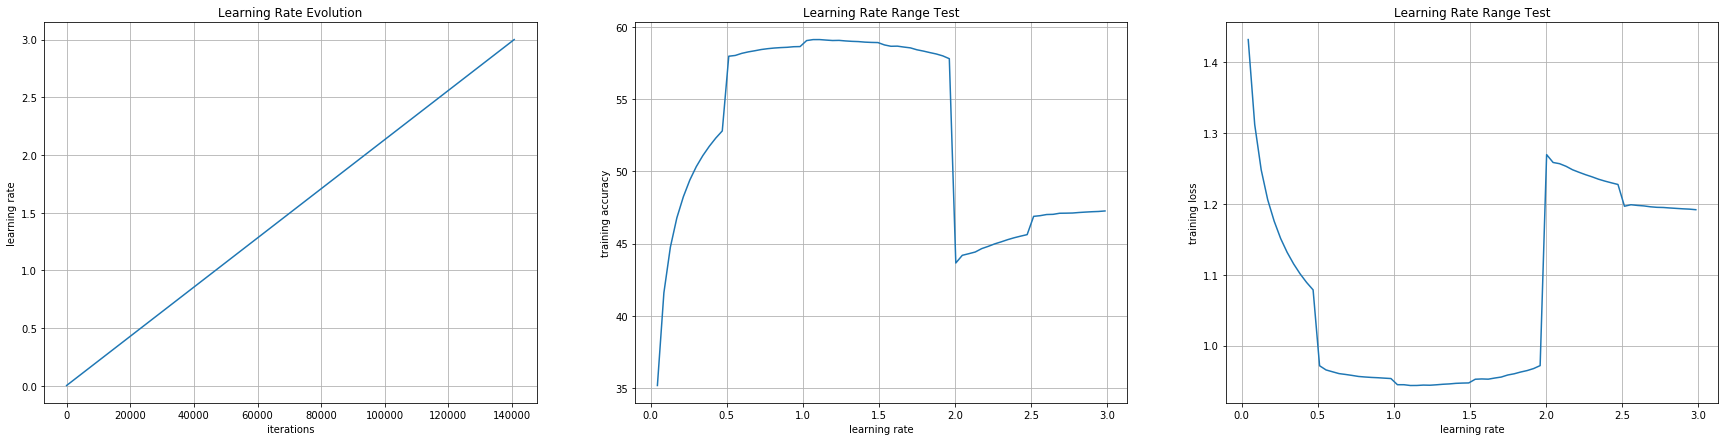

In [14]:
with open(path_to_save + 'han_lr_range_test_trainval_history.json' , 'r', encoding='utf8') as my_file:
    hist = json.load(my_file)

hist = {k:list(map(float,v)) for k,v in hist.items()} # convert strings to floats

n_its_plot = 2000
acc_plot = [elt for idx,elt in enumerate(hist['batch_acc'],1) if idx%n_its_plot==0]
loss_plot = [elt for idx,elt in enumerate(hist['batch_loss'],1) if idx%n_its_plot==0]
lr_plot = [elt for idx,elt in enumerate(hist['batch_lr'],1) if idx%n_its_plot==0]

fig = plt.figure(figsize=(30,7))

plt.subplot(1,3,1)
plt.plot(range(len(hist['batch_lr'])),hist['batch_lr'])
plt.xlabel('iterations')
plt.ylabel('learning rate')
plt.grid(True)
plt.title('Learning Rate Evolution')

plt.subplot(1,3,2)
plt.plot(lr_plot,acc_plot)
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.title('Learning Rate Range Test')

plt.subplot(1,3,3)
plt.plot(lr_plot,loss_plot)
plt.xlabel('learning rate')
plt.ylabel('training loss')
plt.grid(True)
plt.title('Learning Rate Range Test')

plt.show()

We select `max_lr` as the learning rate right before the decrease, and `base_lr` as `max_lr/6`, following Smith's recommendations.

best accuracy: 59.1173
for batch # 52000
with learning rate: 1.109824
base learning rate: 0.18497


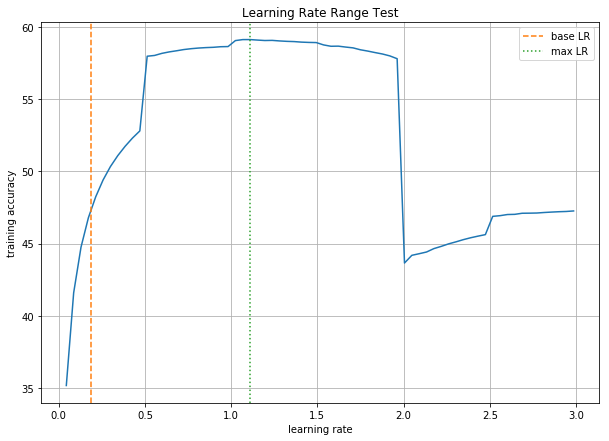

In [15]:
max_lr = float(lr_plot[acc_plot.index(max(acc_plot))])

print('best accuracy:',max(acc_plot))
print('for batch #',(acc_plot.index(max(acc_plot))+1)*n_its_plot)
print('with learning rate:',max_lr)
base_lr = round(max_lr/6,5)
print('base learning rate:',base_lr)

fig = plt.figure(figsize=(10,7))
plt.plot(lr_plot,acc_plot)
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.title('Learning Rate Range Test')
plt.axvline(x=base_lr,label='base LR',c='C1',ls='dashed')
plt.axvline(x=max_lr,label='max LR',c='C2',ls='dotted')
plt.legend()
plt.show()

Note that it's better to record learning rate and accuracy *at the end of every batch* for the learning range test. Using the values at the end of each epoch only gives less precise results, as shown below.

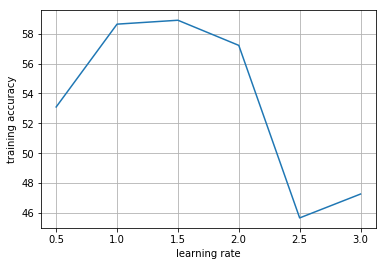

In [25]:
fig = plt.figure()
plt.plot([elt for idx,elt in enumerate(hist['batch_lr'],1) if idx%its_per_epoch_train==0],[round(float(elt)*100,4) for elt in hist['acc']],label='training')
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.show()

## Training <a name='training'></a> <a href="#top">(back to top)</a>
We're now ready to train the model! First, we re-initialize it

In [40]:
han.load_weights(path_to_save + 'han_init_weights')

Then, we instantiate our train and test generators. We use a cycle of 12 epochs, which means that during 6 epochs, the learning rate will increase from `base_lr` to `max_lr`, and for the 6 following epochs, the learning rate will decrease from `max_lr` to `base_lr`. The momentum will do the opposite. Since CLR and CLM work at the granularity of a batch, we must convert our 6 epochs (half cycle) to a number of iterations, `step_size`. This is simply the number of batches per epoch times 6. This procedure will run for 50 epochs, and we use a patience of one cycle.

In [8]:
batch_names_train = [elt for elt in batch_names if 'train_' in elt or 'val_' in elt]
batch_names_val = [elt for elt in batch_names if 'test_' in elt]

nb_epochs = 50
half_cycle = 6 
my_patience = half_cycle*2
its_per_epoch_train = int(len(batch_names_train)/2)
its_per_epoch_val = int(len(batch_names_val)/2)
step_size = its_per_epoch_train*half_cycle

print(its_per_epoch_train,its_per_epoch_val,step_size)

rd_train = read_batches(batch_names_train,
                        path_to_batches,
                        do_shuffle=True,
                        do_train=True,
                        my_max_doc_size_overall=max_doc_size_overall,
                        my_max_sent_size_overall=max_sent_size_overall,
                        my_n_cats=n_cats)

rd_val = read_batches(batch_names_val,
                      path_to_batches,
                      do_shuffle=False,
                      do_train=True,
                      my_max_doc_size_overall=max_doc_size_overall,
                      my_max_sent_size_overall=max_sent_size_overall,
                      my_n_cats=n_cats)

23440 5080 140640


In [42]:
my_optimizer = optimizers.SGD(lr=base_lr,
                              momentum=max_mt, # we decrease momentum when lr increases
                              decay=1e-5,
                              nesterov=True)

han.compile(loss=my_loss,
            optimizer=my_optimizer,
            metrics=['accuracy'])    

lr_sch = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode='triangular')
mt_sch = CyclicMT(base_mt=base_mt, max_mt=max_mt, step_size=step_size, mode='triangular')

early_stopping = EarlyStopping(monitor='val_acc', # go through epochs as long as accuracy on validation set increases
                               patience=my_patience,
                               mode='max')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath=path_to_save + 'han_trained_weights',
                               monitor='val_acc',
                               save_best_only=True,
                               mode='max',
                               verbose=0,
                               save_weights_only=True) # so that we can train on GPU and load on CPU (for CUDNN GRU)

# batch-based callbacks
loss_hist = LossHistory()
acc_hist = AccHistory()
lr_hist = LRHistory()
mt_hist = MTHistory() 

# epoch-based callbacks
pcacc_hist = PerClassAccHistory(my_n_cats=n_cats, my_rd=rd_val, my_n_steps=its_per_epoch_val)

callback_list = [loss_hist,acc_hist,lr_hist,mt_hist,lr_sch,mt_sch,early_stopping,checkpointer,pcacc_hist]

Let's train the model!

In [43]:
han.fit_generator(rd_train, 
                  steps_per_epoch=its_per_epoch_train, 
                  epochs=nb_epochs,
                  callbacks=callback_list,
                  validation_data=rd_val, 
                  validation_steps=its_per_epoch_val,
                  use_multiprocessing=False, 
                  workers=1)

Epoch 1/50
23440/23440 [==============================] - 1298s 55ms/step - loss: 1.0170 - acc: 0.5573 - val_loss: 0.9090 - val_acc: 0.6053
0
1016
2032
3048
4064
Epoch 2/50
23440/23440 [==============================] - 1307s 56ms/step - loss: 0.9393 - acc: 0.5924 - val_loss: 0.8915 - val_acc: 0.6124
0
1016
2032
3048
4064
Epoch 3/50
23440/23440 [==============================] - 1309s 56ms/step - loss: 0.9222 - acc: 0.6005 - val_loss: 0.8828 - val_acc: 0.6176
0
1016
2032
3048
4064
Epoch 4/50
23440/23440 [==============================] - 1235s 53ms/step - loss: 0.9125 - acc: 0.6043 - val_loss: 0.8759 - val_acc: 0.6205
0
1016
2032
3048
4064
Epoch 5/50
23440/23440 [==============================] - 1235s 53ms/step - loss: 0.9058 - acc: 0.6076 - val_loss: 0.8698 - val_acc: 0.6228
0
1016
2032
3048
4064
Epoch 6/50
23440/23440 [==============================] - 1236s 53ms/step - loss: 0.9010 - acc: 0.6096 - val_loss: 0.8787 - val_acc: 0.6152
0
1016
2032
3048
4064
Epoch 7/50
23440/23440 [====

As for the learning rate range test, we save the model's history.

In [45]:
hist = han.history.history
print(hist.keys())
print(len(lr_hist.lrs))
hist['batch_loss'] = loss_hist.loss_avg
hist['batch_acc'] = acc_hist.acc_avg
hist['batch_lr'] = lr_hist.lrs
hist['batch_mt'] = mt_hist.mts
hist['pcacc'] = pcacc_hist.per_class_accuracy

hist = {k: [str(elt) for elt in v] for k, v in hist.items()}
with open(path_to_save + 'han_history.json', 'w') as my_file:
    json.dump(hist, my_file, sort_keys=False, indent=4)

dict_keys(['loss', 'batch_lr', 'val_acc', 'batch_acc', 'acc', 'val_loss', 'batch_loss', 'batch_mt'])
1172000


## Results <a name='results'></a> <a href="#top">(back to top)</a>
We can immediately see that we reach **62.6%** accuracy after 8 epochs, and that we reproduce the results of the HAN paper (**63.6%** accuracy) after 42 epochs! We even slightly exceed this accuracy later on. Each epoch takes about 20 mins on my TitanX GPU. Let's now analyze the results in more details. First, a define a convenient function to generate some useful plots.

In [27]:
def plot_results(my_results,loss_acc_lr,my_title):
    assert loss_acc_lr in ['loss','acc','lr'], 'invalid 2nd argument!'
    n_epochs = len(my_results['loss'])
    if loss_acc_lr in ['loss','acc']:
        plt.plot(range(1,n_epochs+1),my_results['val_' + loss_acc_lr],label='validation')
        plt.plot(range(1,n_epochs+1),my_results[loss_acc_lr],label='training')
    else:
        plt.plot(range(1,n_epochs+1),my_results['lr'],label='learning rate')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel(loss_acc_lr)
    plt.xlim([1,n_epochs+1])
    plt.grid(True)
    plt.title(my_title)

In [29]:
with open(path_to_save + 'han_history.json' , 'r', encoding='utf8') as my_file:
    histt = json.load(my_file)

# convert strings to floats
histt = {k:list(map(float,v)) for k,v in histt.items() if k!='pcacc'}

lr_epoch = [elt for idx,elt in enumerate(histt['batch_lr'],1) if idx%its_per_epoch_train==0]
print(len(lr_epoch))
histt['lr'] = lr_epoch

50


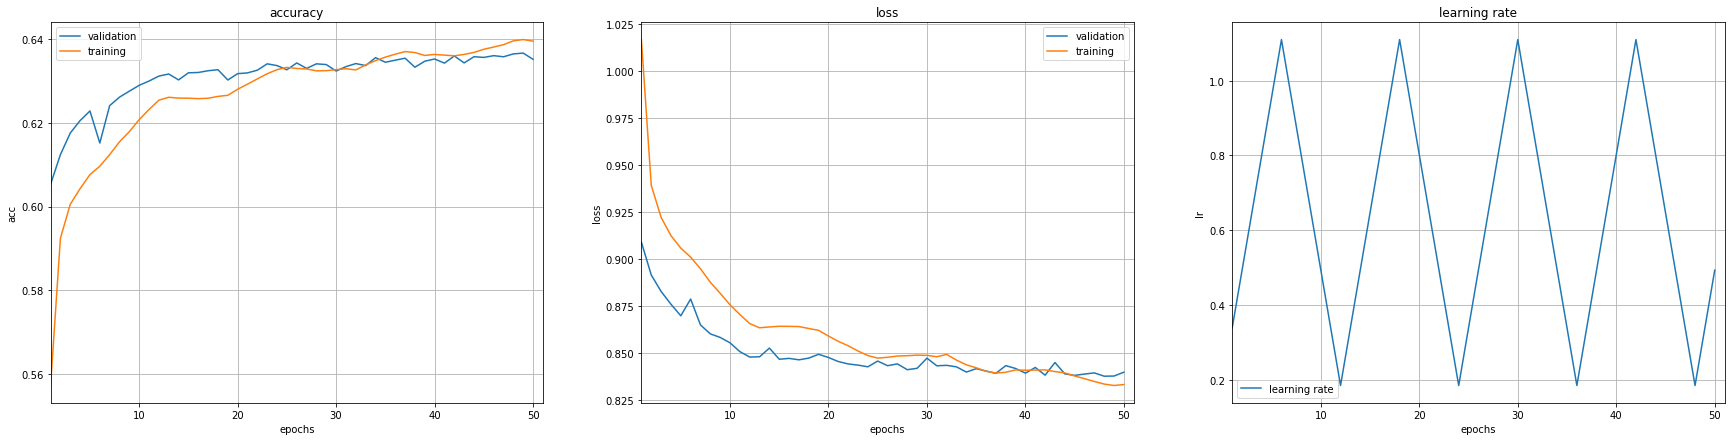

In [31]:
fig = plt.figure(figsize=(30,7))
plt.subplot(1,3,1)
plot_results(histt,'acc','accuracy')
plt.subplot(1,3,2)
plot_results(histt,'loss','loss')
plt.subplot(1,3,3)
plot_results(histt,'lr','learning rate')
plt.show()

Good advice to interpret our basic plots can be found on Stanford's CS231n course page, [here](http://cs231n.github.io/neural-networks-3/#baby) (section "Babysitting the learning process").

- We can observe on the first plot that we don't start overfitting before the 35th epoch or so, and that even then, we only slighlty overfit. This indicates that our regularization strategy (dropout and large learning rate at times) is effective, which is is a good thing.

-  We can also see on the second plot that our loss VS epochs curve seems neither too linear nor too exponential, which indicates that the learning rate is adequate.

- Of course, on the third plot, we can observe our triangular CLR policy. Looking more closely at the plot below (where the vertical dotted lines represent the end of each half cycle), we can clearly see that **when the learning rate increases** (odd half cycles), the performance of the model **plateaus or slightly decreases**, and that **when the learning rate decreases, performance increases**. This is especially obvious looking at the training accuracy curve (the orange one). This is consistent with Smith's observation that *CLR might harm short term performance, but is beneficial in the long run*.

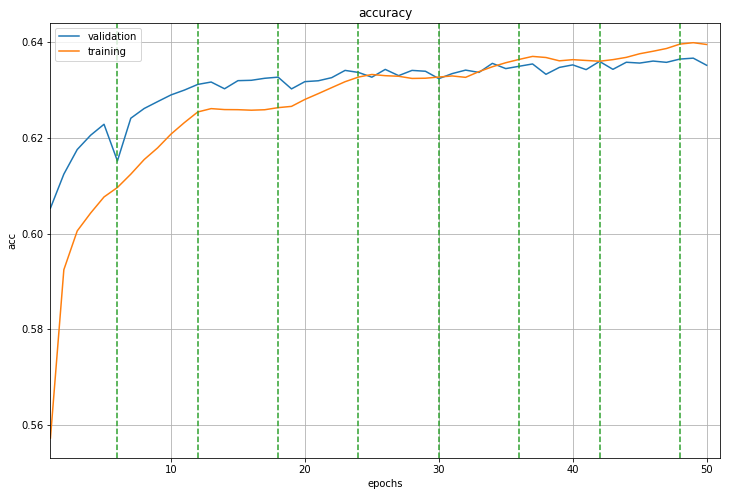

In [72]:
fig = plt.figure(figsize=(12,8))
plot_results(histt,'acc','accuracy')
for ep_idx,foo in enumerate(range(nb_epochs),1):
    if ep_idx % half_cycle == 0:
        plt.axvline(x=ep_idx, c='C2',ls='dashed')

## Visualization of document embeddings <a name='embeddings'></a> <a href="#top">(back to top)</a>
### After training
You can download the weights of the trained model [here](https://www.dropbox.com/s/tiehrbjq824kjlo/han_trained_weights?dl=0) (~135MB). We load `n_batch_show` batches with our generator in trained mode, so that we can get both the documents and their labels. Then, we feed each document to an intermediate model corresponding to HAN without the last dense layer. This gives us the vectors of all the documents. Finally, we use PCA and the labels to visualize in two dimensions whether the internal representations of the **trained model** are correlated with the labels. We can clearly see that they do: the negative reviews are on one side, the positive on the other side, and the neutral in the middle. The fact that the model learned sensible representations was expected in light of the good accuracy that it reached.

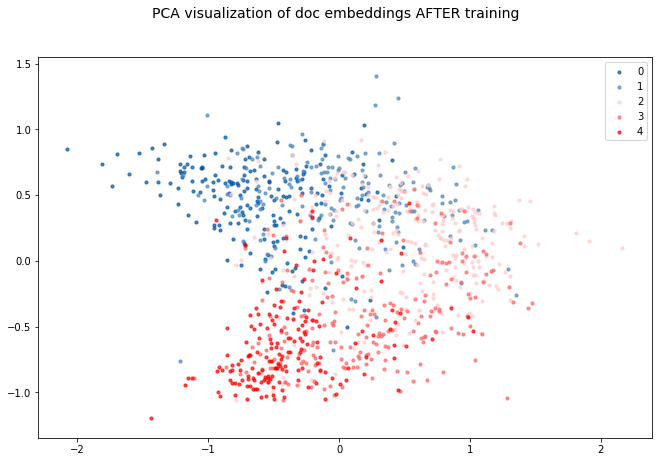

In [18]:
han.load_weights(path_to_save + 'han_trained_weights')

get_doc_embeddings = Model(doc_ints,doc_att_vec_dr)

rd_inf = read_batches(batch_names_val,
                      path_to_batches,
                      do_shuffle=False,
                      do_train=True,
                      my_max_doc_size_overall=max_doc_size_overall,
                      my_max_sent_size_overall=max_sent_size_overall,
                      my_n_cats=n_cats)

n_batch_show = 8

docs = []
labels = []
for rep in range(n_batch_show):
    batch_tmp = rd_inf.__next__()
    docs.append(batch_tmp[0])
    labels = labels + batch_tmp[1].tolist()

labels = [elt.index(1.0) for elt in labels]

doc_emb_dim = 100
doc_embs = np.empty((0,doc_emb_dim))
for doc in docs:
    doc_emb = get_doc_embeddings.predict(doc)
    doc_embs = np.append(doc_embs,doc_emb,axis=0)

my_pca = PCA(n_components=2)
doc_embs_pca = my_pca.fit_transform(doc_embs)

my_colors = ['#0055a4','#4c88bf','#ffcccc','#ff6666','#ff0000']
fig, ax = plt.subplots()
for label in list(set(labels)):
    idxs = [idx for idx,elt in enumerate(labels) if elt==label]
    ax.scatter(doc_embs_pca[idxs,0], 
               doc_embs_pca[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('PCA visualization of doc embeddings AFTER training',fontsize=14)
fig.set_size_inches(11,7)
fig.show()

### Before training
Of course, if we go back to the model **before training**, the internal representations don't make any sense!

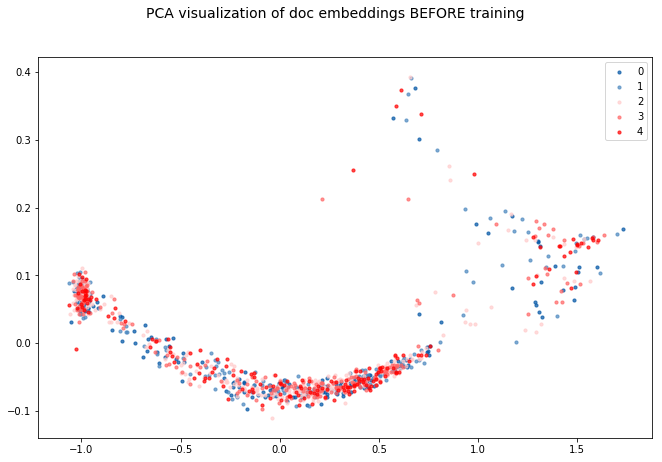

In [17]:
han.load_weights(path_to_save + 'han_init_weights')

doc_emb_dim = 100
doc_embs = np.empty((0,doc_emb_dim))
for doc in docs:
    doc_emb = get_doc_embeddings.predict(doc)
    doc_embs = np.append(doc_embs,doc_emb,axis=0)

my_pca = PCA(n_components=2)
doc_embs_pca = my_pca.fit_transform(doc_embs)

fig, ax = plt.subplots()
for label in list(set(labels)):
    idxs = [idx for idx,elt in enumerate(labels) if elt==label]
    ax.scatter(doc_embs_pca[idxs,0], 
               doc_embs_pca[idxs,1], 
               c = my_colors[label],
               label=str(label),
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('PCA visualization of doc embeddings BEFORE training',fontsize=14)
fig.set_size_inches(11,7)
fig.show()

## Getting attention coefficients <a name='attention'></a> <a href="#top">(back to top)</a>

In [29]:
sess = tf.Session()
K.set_session(sess)

han.load_weights(path_to_save + 'han_trained_weights')

with open(path_root + 'vocab.json', 'r') as my_file:
    word_to_index_han = json.load(my_file)
    
padding_idx = 0
oov_idx = 1

get_sent_att_coeffs = Model(sent_ints,sent_att_coeffs) # coeffs over the words in a sentence
get_doc_attention_coeffs = Model(doc_ints,doc_att_coeffs) # coeffs over the sentences in a document 

# ===== toy example =====

text = "Excellent product. This was exactly what I needed. I highly recommend it! :-)"

# == preprocessing ==
sents = sent_tokenize(text)
sents_idxs = []
sents_tokenized = []
for sent in sents:
    words = word_tokenize(sent)
    sents_tokenized.append(words)
    idxs = [word_to_index_han[elt] if elt in word_to_index_han else oov_idx for elt in words]
    sents_idxs.append(idxs)

max_sent_size = min(max([len(s) for s in sents_idxs]),max_sent_size_overall)
sents_idxs_padded = [s+[padding_idx]*(max_sent_size-len(s)) if len(s)<max_sent_size else s[:max_sent_size] for s in sents_idxs]
reshaped_sentences = np.reshape(np.array(sents_idxs_padded),(1,len(sents),max_sent_size))
reshaped_sentences_tensor = _to_tensor(reshaped_sentences,dtype='float32') # a layer, unlike a model, requires tf tensor as input

print('== attention over words ==')
sents_att_coeffs = TimeDistributed(get_sent_att_coeffs)(reshaped_sentences_tensor)
word_coeffs = sents_att_coeffs.eval(session=sess)
word_coeffs = np.reshape(word_coeffs,(len(sents),max_sent_size))

my_wcs = []
for my_idx,wc in enumerate(word_coeffs):
    my_keys = sents_tokenized[my_idx]
    my_values = [round(elt*1e3,2) for elt in wc.tolist()[:len(my_keys)]]
    my_wcs.append(list(zip(my_keys,my_values)))

print(my_wcs)
    
print('== attention over sentences ==')
sent_coeffs = get_doc_attention_coeffs.predict(reshaped_sentences)
sent_coeffs = sent_coeffs.flatten()

print(list(zip(sents,sent_coeffs)))

== attention over words ==
[[('Excellent', 494.95), ('product', 40.84), ('.', 366.23)], [('This', 135.66), ('was', 104.97), ('exactly', 382.57), ('what', 133.47), ('I', 67.65), ('needed', 56.65), ('.', 118.71)], [('I', 270.04), ('highly', 367.26), ('recommend', 280.12), ('it', 35.22), ('!', 34.79)], [(':', 92.81), ('-', 60.18), (')', 707.43)]]
== attention over sentences ==
[('Excellent product.', 0.20189385), ('This was exactly what I needed.', 0.48167485), ('I highly recommend it!', 0.27260393), (':-)', 0.04382727)]


# Thank you for your interest!
If you found any error or have any suggestion for improvement, please file an issue on GitHub. You can also contact me at `antoine.tixier-1@colorado.edu`.